# Importing Libraries

In [1]:
# Trivial libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
# Additional libraries.

#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#!pip install geopy


# Predicting Meds

In [3]:
# Importing the VAERS report dataset.
df1 = pd.read_csv("..//Datasets//2021VAERSData.csv", encoding='latin1')

# Removing columns with 90% NaN values.
df1.drop(["RPT_DATE", "V_FUNDBY", "CAGE_MO", "BIRTH_DEFECT", "RECVDATE", "TODAYS_DATE", "SPLTTYPE", "SYMPTOM_TEXT"], axis=1, inplace=True)

# Mean imputation on numerical columns.
df1['AGE_YRS'].fillna(round(df1['AGE_YRS'].mean()), inplace = True)
df1['CAGE_YR'].fillna(round(df1['CAGE_YR'].mean()), inplace = True)
df1['HOSPDAYS'] = df1.apply(
    lambda row: 0 if pd.isnull(row['HOSPITAL']) else row['HOSPDAYS'],
    axis = 1
)

df1['HOSPDAYS'].fillna(round(df1['HOSPDAYS'].mean()), inplace = True)
df1['NUMDAYS'].fillna(round(df1['NUMDAYS'].mean()), inplace = True)

# Filling categorical columns with mode.
df1.fillna(df1.mode().iloc[0], inplace = True)
df1


,VAERS_ID,STATE,AGE_YRS,CAGE_YR,SEX,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,...,LAB_DATA,V_ADMINBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,FORM_VERS,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,TX,33.0,33.0,F,Y,02/01/2021,Y,Y,Y,...,None,PVT,None,None,None,Flu,2,Y,Y,Pcn and bee venom
1,916601,CA,73.0,73.0,F,Y,02/01/2021,Y,Y,Y,...,None,SEN,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,Flu,2,Y,Y,"""Dairy"""
2,916602,WA,23.0,23.0,F,Y,02/01/2021,Y,Y,Y,...,None,SEN,None,None,None,Flu,2,Y,Y,Shellfish
3,916603,WA,58.0,58.0,F,Y,02/01/2021,Y,Y,Y,...,none,WRK,none,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",2,Y,Y,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,TX,47.0,47.0,F,Y,02/01/2021,Y,Y,Y,...,None,PUB,Na,Na,None,Flu,2,Y,Y,Na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27950,1092595,TX,70.0,70.0,F,Y,02/01/2021,Y,Y,Y,...,None,PVT,None,None,None,Flu,2,Y,Y,NKA
27951,1092651,CA,77.0,77.0,M,Y,02/27/2021,Y,Y,Y,...,None,PHM,"HTN, DM, Cholesterol and blood thinners",+Covid in January 2021,Cardiac,Flu,2,Y,Y,None
27952,1092653,CA,88.0,88.0,F,Y,03/10/2021,Y,Y,Y,...,Patient expired.,SEN,"Vitamin B12,C,D3. Eyedrops, probiotics","Bladder cancer, Malignant melanoma, both in re...","Interstitial cystitis, mitral valve prolapse, ...",Flu,2,Y,Y,robitussin
27953,1092737,ME,69.0,69.0,M,Y,03/11/2021,Y,Y,Y,...,Ambulance personnel pronounced dead at scene,PHM,Levothyroxine Insulin Diabetes meds,None,"Diabetes, coronary artery disease, hypothyroidism",Flu,2,Y,Y,None known


In [4]:
# Importing the VAERS sympotoms and vaccine datasets.
df2 = pd.read_csv("..//Datasets//2021VAERSSYMPTOMS.csv", encoding='latin1')
df3 = pd.read_csv("..//Datasets//2021VAERSVAX.csv", encoding='latin1')

# Pre-processing both the datasets.
df2 = df2.dropna(axis = 0)
df2.drop(["SYMPTOMVERSION1", "SYMPTOMVERSION2", "SYMPTOMVERSION3", "SYMPTOMVERSION4", "SYMPTOMVERSION5"], axis=1, 
         inplace=True)

df3.drop(["VAX_LOT", "VAX_SITE"], axis=1, inplace=True)
df3.fillna(df3.mode().iloc[0], inplace = True)


In [5]:
# Making the final patient dataset.
# Would be used to predict the medical needs of a particular patient.

df4 = pd.concat([df1, df2, df3], axis=1, join="inner")

# Some pre-processing.
df4.reset_index(inplace = True)
df4.drop(["DIED","VAX_TYPE","VAX_NAME","VAX_ROUTE","CAGE_YR"], axis=1, inplace=True)

df4.to_csv('C:\\Users\\Ayanabha\\Blueronic\\Datasets\\df4_mod.csv')

df4


,index,VAERS_ID,STATE,AGE_YRS,SEX,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,...,ALLERGIES,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,VAERS_ID,VAX_MANU,VAX_DOSE_SERIES
0,10,916611,NC,33.0,F,02/01/2021,Y,Y,Y,0.0,...,Dust mites Zoloft Wellbutrin Buspar,916611,Blood pressure decreased,Chest pain,Chills,Confusional state,Decreased appetite,916611,MODERNA,1
1,11,916613,CA,40.0,F,02/01/2021,Y,Y,Y,0.0,...,None,916611,Dyspnoea,Fatigue,Feeling abnormal,Head discomfort,Headache,916613,MODERNA,1
2,12,916614,NY,29.0,F,02/01/2021,Y,Y,Y,0.0,...,None,916611,Heart rate decreased,Heart rate increased,Hypertension,Injection site pain,Musculoskeletal chest pain,916614,MODERNA,1
3,13,916615,NY,38.0,F,02/01/2021,Y,Y,Y,0.0,...,"Sulfa, steri strips, adhesive bandages",916611,Nausea,Pain,Pain in extremity,Paraesthesia oral,Pyrexia,916615,MODERNA,1
4,17,916620,NJ,65.0,M,02/01/2021,Y,Y,Y,0.0,...,None,916615,Injection site erythema,Injection site pruritus,Injection site swelling,Lymph node pain,Lymphadenopathy,916620,MODERNA,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10772,27946,1092214,ME,66.0,M,03/05/2021,Y,Y,Y,0.0,...,Losartan Simvastatin Amlodipine,1037873,Hyperhidrosis,Hypotension,Malaise,Nausea,Pain in extremity,1080851,MODERNA,2
10773,27948,1092483,IA,67.0,F,03/11/2021,Y,Y,Y,0.0,...,"Combivent, gabapentin, tramadol.",1037874,Cardiac flutter,Chest pain,Dizziness,Dyspnoea,Feeling hot,1080983,PFIZER\BIONTECH,2
10774,27950,1092595,TX,70.0,F,02/01/2021,Y,Y,Y,0.0,...,NKA,1037875,Balance disorder,Dizziness,Fall,Hypoaesthesia,Muscular weakness,1081009,MODERNA,1
10775,27952,1092653,CA,88.0,F,03/10/2021,Y,Y,Y,0.0,...,robitussin,1037877,COVID-19,Echocardiogram,Fall,Hip fracture,SARS-CoV-2 test,1081033,MODERNA,2


In [6]:
# Importing the supply chain dataset.

df5 = pd.read_csv("..//Datasets//SCMS_Delivery_History_Dataset.csv")


df5.to_csv('C:\\Users\\Ayanabha\\Blueronic\\Datasets\\df5_mod.csv')

df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,...,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,Freight Included in Commodity Cost,134.03


In [7]:
# Make X & Y for meds prediction.

X = df4[['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']].copy()
Y = df4[['OTHER_MEDS']].copy()


In [8]:
X['Mixed'] = X[X.columns[0:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X['Mixed'])

filename='C:\\Users\\Ayanabha\\Blueronic\\Models\\TFIDF.pkl'
pickle.dump(vectorizer, open(filename, 'wb'))

In [9]:
# Converting X from Sparse Matrix to Pandas Dataframe.

import scipy.sparse
X = pd.DataFrame.sparse.from_spmatrix(X)
X


,0,1,2,3,4,5,6,7,8,9,...,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.356371,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10772,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10773,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10774,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10775,0.291465,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


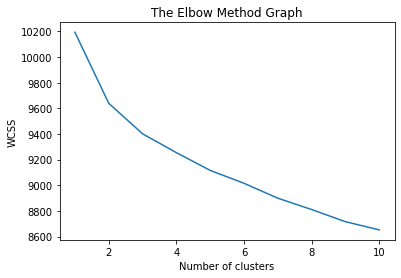

In [10]:
# Using the elbow method to get the optimum number of clusters.

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
wcss=[]

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [11]:
# Perform K-Means Clustering of the data & predict the clusters.

kmeans = KMeans(n_clusters=3, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_kmeans = kmeans.fit_predict(X)
y_kmeans


array([0, 0, 0, ..., 0, 0, 0])

In [12]:
# Counting number of elements in each cluster.

temp = dict()

for i in y_kmeans.tolist():
    temp[i] = 0
    
for i in y_kmeans.tolist():
    temp[i] += 1
    
print(temp)


{0: 6706, 2: 2474, 1: 1597}


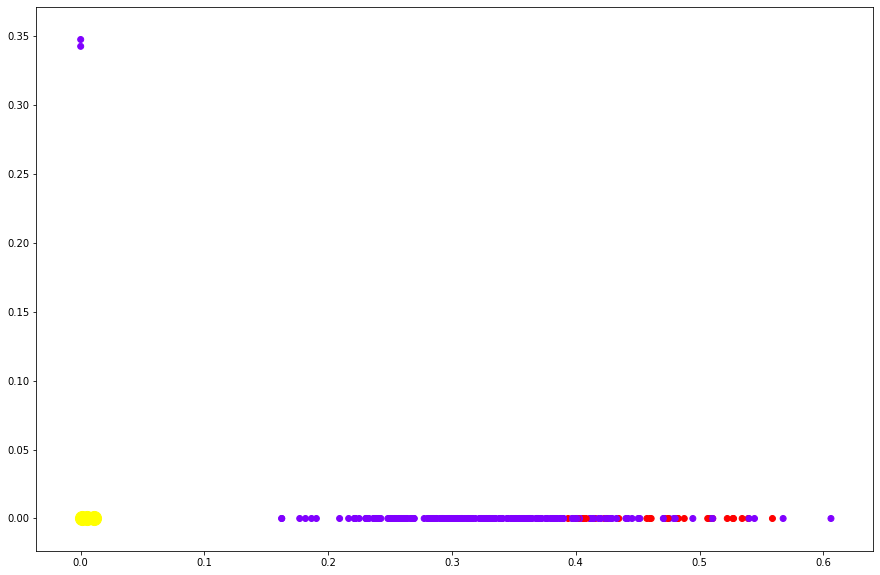

In [13]:
# Plotting the clusters.

plt.figure(figsize=(15, 10))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='yellow', label = 'Centroids')
plt.show()


In [14]:
# Appending cluster labels.

df4['Cluster'] = y_kmeans.tolist()
df4


,index,VAERS_ID,STATE,AGE_YRS,SEX,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,...,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,VAERS_ID,VAX_MANU,VAX_DOSE_SERIES,Cluster
0,10,916611,NC,33.0,F,02/01/2021,Y,Y,Y,0.0,...,916611,Blood pressure decreased,Chest pain,Chills,Confusional state,Decreased appetite,916611,MODERNA,1,0
1,11,916613,CA,40.0,F,02/01/2021,Y,Y,Y,0.0,...,916611,Dyspnoea,Fatigue,Feeling abnormal,Head discomfort,Headache,916613,MODERNA,1,0
2,12,916614,NY,29.0,F,02/01/2021,Y,Y,Y,0.0,...,916611,Heart rate decreased,Heart rate increased,Hypertension,Injection site pain,Musculoskeletal chest pain,916614,MODERNA,1,0
3,13,916615,NY,38.0,F,02/01/2021,Y,Y,Y,0.0,...,916611,Nausea,Pain,Pain in extremity,Paraesthesia oral,Pyrexia,916615,MODERNA,1,2
4,17,916620,NJ,65.0,M,02/01/2021,Y,Y,Y,0.0,...,916615,Injection site erythema,Injection site pruritus,Injection site swelling,Lymph node pain,Lymphadenopathy,916620,MODERNA,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10772,27946,1092214,ME,66.0,M,03/05/2021,Y,Y,Y,0.0,...,1037873,Hyperhidrosis,Hypotension,Malaise,Nausea,Pain in extremity,1080851,MODERNA,2,2
10773,27948,1092483,IA,67.0,F,03/11/2021,Y,Y,Y,0.0,...,1037874,Cardiac flutter,Chest pain,Dizziness,Dyspnoea,Feeling hot,1080983,PFIZER\BIONTECH,2,0
10774,27950,1092595,TX,70.0,F,02/01/2021,Y,Y,Y,0.0,...,1037875,Balance disorder,Dizziness,Fall,Hypoaesthesia,Muscular weakness,1081009,MODERNA,1,0
10775,27952,1092653,CA,88.0,F,03/10/2021,Y,Y,Y,0.0,...,1037877,COVID-19,Echocardiogram,Fall,Hip fracture,SARS-CoV-2 test,1081033,MODERNA,2,0


In [15]:
# Making a column for meds.

l=[]

for i in df4['OTHER_MEDS']:
    if(',' in i):
        temp=i.split(',')
        
        for j in range(len(temp)):
            temp[j]=temp[j].strip()
        
        l.extend(temp)
    elif(' ' not in i):
        l.append(i.strip())
        
l=list(set(l))

import random
meds=[random.choice(l) for i in range(len(df4))]
df4['meds']=meds
df4


,index,VAERS_ID,STATE,AGE_YRS,SEX,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,...,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,VAERS_ID,VAX_MANU,VAX_DOSE_SERIES,Cluster,meds
0,10,916611,NC,33.0,F,02/01/2021,Y,Y,Y,0.0,...,Blood pressure decreased,Chest pain,Chills,Confusional state,Decreased appetite,916611,MODERNA,1,0,Chlorhexidine rinse
1,11,916613,CA,40.0,F,02/01/2021,Y,Y,Y,0.0,...,Dyspnoea,Fatigue,Feeling abnormal,Head discomfort,Headache,916613,MODERNA,1,0,OTC .81 mg aspirin and nitrofurantoin
2,12,916614,NY,29.0,F,02/01/2021,Y,Y,Y,0.0,...,Heart rate decreased,Heart rate increased,Hypertension,Injection site pain,Musculoskeletal chest pain,916614,MODERNA,1,0,Wixela
3,13,916615,NY,38.0,F,02/01/2021,Y,Y,Y,0.0,...,Nausea,Pain,Pain in extremity,Paraesthesia oral,Pyrexia,916615,MODERNA,1,2,Toprol-XL
4,17,916620,NJ,65.0,M,02/01/2021,Y,Y,Y,0.0,...,Injection site erythema,Injection site pruritus,Injection site swelling,Lymph node pain,Lymphadenopathy,916620,MODERNA,1,1,Natures Bnty Hair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10772,27946,1092214,ME,66.0,M,03/05/2021,Y,Y,Y,0.0,...,Hyperhidrosis,Hypotension,Malaise,Nausea,Pain in extremity,1080851,MODERNA,2,2,Jantoven
10773,27948,1092483,IA,67.0,F,03/11/2021,Y,Y,Y,0.0,...,Cardiac flutter,Chest pain,Dizziness,Dyspnoea,Feeling hot,1080983,PFIZER\BIONTECH,2,0,sumatriptan 50 mg as needed
10774,27950,1092595,TX,70.0,F,02/01/2021,Y,Y,Y,0.0,...,Balance disorder,Dizziness,Fall,Hypoaesthesia,Muscular weakness,1081009,MODERNA,1,0,LACTOBACILLUS
10775,27952,1092653,CA,88.0,F,03/10/2021,Y,Y,Y,0.0,...,COVID-19,Echocardiogram,Fall,Hip fracture,SARS-CoV-2 test,1081033,MODERNA,2,0,metoprolol tart 50mg bid


In [16]:
medlist=list(df4['meds'])
filename='C:\\Users\\Ayanabha\\Blueronic\\Models\\meds.pkl'
pickle.dump(medlist, open(filename, 'wb'))

In [17]:
# Taking user medicine input.
inp = X.iloc[0, :]


In [18]:
# KNN algorithm for suggesting meds.

from sklearn.neighbors import KNeighborsClassifier

k = 3

neigh = KNeighborsClassifier(n_neighbors = k)
neigh.fit(X, y_kmeans.tolist())

filename='C:\\Users\\Ayanabha\\Blueronic\\Models\\knn.pkl'
pickle.dump(neigh, open(filename, 'wb'))

distances, indices = neigh.kneighbors([inp])

print(indices)


[[   0 7875 7642]]


In [19]:
# Making a list for predicted meds.

predicted_meds = []

for i in indices.ravel():
    predicted_meds.append(df4['meds'][i])
print(predicted_meds)

['Chlorhexidine rinse', 'Metformin 250 mg', 'zafirlukast']


In [20]:
# Randomly assigning meds and adding them to df5.

import random

meds = [random.choice(l) for i in range(len(df5))]
df5['Item Description'] = meds


In [21]:
# Making the weight column numeric.

x = df5['Weight (Kilograms)']

total = 0
count = 0
for i in x:
    if i.isnumeric():
        total += float(i)
        count += 1
average = total/count

for i in range(len(x)):
    if not x[i].isnumeric():
        x[i] = average
        

D:\Anaconda_Navigator\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [22]:
df5['Weight (Kilograms)'] = x

In [23]:
x2 = set(df4['meds'])
x2

{'',
 'Balsalazide 750 3 caps tid',
 'Aspirin 250mg (2 daily)',
 'symbicort inhaler',
 'and E',
 'uloric 40 mg daily',
 'alprazolam',
 'One-a-day multivitamin',
 'ELDERBERRY',
 'apixaban 5mg x1 every 12 hrs',
 'Supplements:  Krill Oil',
 "women's daily vitamin",
 'as well as regular medications',
 '000 unit tablet clopidogrel (PLAVIX) 75 mg tablet EPINEPHrine (EPIPEN) 0.3 mg/0.3 mL AtIn famotidine (PEPCID) 20 MG tablet furosemide (LASIX) 20 MG tablet',
 'B 12',
 'dabigatran 150 mg bid',
 'Ventolin HSA inhaler',
 'Celecoxib',
 'Glucose Essentials',
 'Fluoxetine 10MG 1 tab daily HS',
 'Vitamin B 12',
 'Ativan',
 'fexofenadine 180mg daily',
 'Rosovustatin',
 '81mg asprin',
 'hydralazine HCL',
 'Aspirin 81 Mg',
 'Norvasc',
 'Type 2 diabetes medicine: insulin',
 'triamcinolone cream',
 'multi-vits',
 'magnesium chloride',
 'Mg',
 'VITAMIN D',
 'loose stools. cough',
 'doxycycline antibiotic',
 'Famotidine isosorbide atorvastatin',
 'Eliquis',
 'plaquenil routine and cyclobenzadine and predn

In [24]:
# Appending meds suggestion count to a file.

a = open('..//Medications//Medications.txt', 'a')

for i in x2:
    a.write(str(i+'$' + str(random.randint(1, 1000)) + '\n'))

a.close()


In [25]:
# Storing data from file in a dictionary.

l = dict()
a = open('..//Medications//Medications.txt', 'r')

Lines = a.readlines()
 
# Strips the newline character
for line in range(len(Lines)-1):
    temp = Lines[line].split('$')
    l[temp[0]] = int(temp[1].replace('\n','').strip())

a.close()
    

In [26]:
# Making an item description column in df5.

x1 = []

for i in df5['Item Description']:
    if i in l.keys():
        x1.append(l[i])
    else:
        x1.append(np.nan)

df5['Suggest count'] = x1
df5['Suggest count'].fillna(df5['Suggest count'].median(), inplace=True)

df5.to_csv('C:\\Users\\Ayanabha\\Blueronic\\Datasets\\df_inventory.csv')

df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Suggest count
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN,665
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN,308
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN,977
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN,807
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN,915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,3424.44,See DN-4307 (ID#:83920),705.79,379
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,...,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,3424.44,See DN-4313 (ID#:83921),161.71,415
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,3424.44,Freight Included in Commodity Cost,5284.04,524
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,Freight Included in Commodity Cost,134.03,640


# Inventory Management Model

In [27]:
# TODOs.

# 1. Subset the rows corresponding to predicted meds to be used as data for MLR. 


In [28]:
# Multiple linear regression.

from sklearn import linear_model

X = df5[['Weight (Kilograms)', 'Suggest count']].astype(float)
y = df5['Line Item Quantity']

regr = linear_model.LinearRegression()
regr.fit(X, y)

filename='C:\\Users\\Ayanabha\\Blueronic\\Models\\multi_regr.pkl'
pickle.dump(regr, open(filename, 'wb'))

In [29]:
x_pred = [[float(df5['Weight (Kilograms)'][0]), float(df5['Suggest count'][0])]]
regr.predict(x_pred)

array([14380.06636271])

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
y_pred = regr.predict(X_test)

In [33]:
print(y_pred)

[25577.19418702 18150.73514627 18486.72284333 ... 16473.50021916
 25761.29477597 16064.20037008]


In [34]:
from sklearn.metrics import r2_score, mean_absolute_error
r2_score(y_test, y_pred)

mean_absolute_error(y_test, y_pred)

20911.003119891855

# Demand Estimation

In [35]:
predicted_meds = pickle.load(open('C:\\Users\\Ayanabha\\Blueronic\\Models\\predmed.pkl','rb'))

In [36]:
# Making a new dataframe (df6) of predicted meds instances.

df6=pd.DataFrame(columns=['Scheduled Delivery Date','Line Item Quantity','Line Item Value'])

l1=[]
l2=[]
l3=[]

for i in range(len(df5['Item Description'])):
    if(df5['Item Description'][i]== predicted_meds[0] or df5['Item Description'][i]==predicted_meds[1] or df5['Item Description'][i]==predicted_meds[2]):
        print(df5.iloc[i,:]["Line Item Quantity"])
        l1.append(df5.iloc[i,:]['Scheduled Delivery Date'])
        l2.append(df5.iloc[i,:]['Line Item Quantity'])
        l3.append(df5.iloc[i,:]['Line Item Value'])

df6['Scheduled Delivery Date']=l1
df6['Line Item Quantity']=l2
df6['Line Item Value']=l3        

df6


346
740
11811
415
39939
50000


,Scheduled Delivery Date,Line Item Quantity,Line Item Value
0,25-Jun-09,346,1954.90
1,21-Sep-07,740,36496.80
2,17-Oct-13,11811,69684.90
3,8-Sep-10,415,2905.00
4,22-Jan-10,39939,134594.43
5,30-Sep-10,50000,286500.00


In [37]:
# Preprocessing the dataset (df6) for 'Demand Estimation'.

df6["Scheduled Delivery Date"]= pd.to_datetime(df6["Scheduled Delivery Date"],format='%d-%b-%y')
df6 = df6.sort_values(by="Scheduled Delivery Date")
df6.reset_index(inplace=True)
df6.drop(['index'],axis=1,inplace=True)
df6


,Scheduled Delivery Date,Line Item Quantity,Line Item Value
0,2007-09-21,740,36496.80
1,2009-06-25,346,1954.90
2,2010-01-22,39939,134594.43
3,2010-09-08,415,2905.00
4,2010-09-30,50000,286500.00
5,2013-10-17,11811,69684.90


In [38]:
# ARIMA forecasting of line item quantity and line item value.

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
 
casemodel = ARIMA(df6['Line Item Quantity'], order=(1, 0, 0))
casemodel_fit = casemodel.fit(disp=0)


In [39]:
# Forecasting line item quantity using ARIMA
Y_forecast_arima = casemodel_fit.forecast(steps = df6.shape[0])[0]
Y_forecast_arima


array([21908.74483957, 16909.66962784, 19384.55420549, 18159.31685393,
       18765.89324995, 18465.59639421])

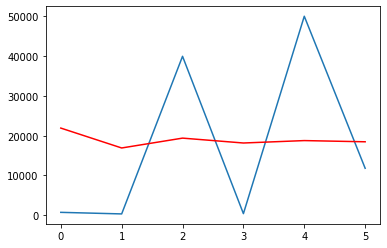

In [40]:
# Plotting the original and forecasted line item quantity.

plt.plot(df6.index,df6['Line Item Quantity'])
plt.plot(df6.index,list(Y_forecast_arima),color='red')
plt.show()


In [41]:
# ARIMA forecasting of line item value.

casemodel = ARIMA(df6['Line Item Value'], order=(1, 0, 0))
casemodel_fit = casemodel.fit(disp=0)
Y_forecast_arima = casemodel_fit.forecast(steps = df6.shape[0])[0]
Y_forecast_arima


array([101026.23670834,  89318.30228598,  93691.94243139,  92058.11639244,
        92668.45181941,  92440.45365771])

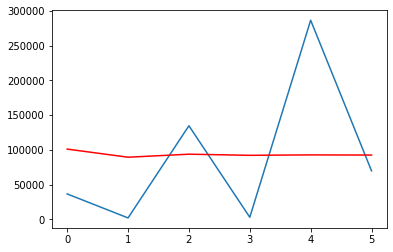

In [42]:
# Plotting the original and forecasted line item value.

plt.plot(df6.index,df6['Line Item Value'])
plt.plot(df6.index,list(Y_forecast_arima),color='red')
plt.show()


# Production

In [43]:
# Making a copy of df5.

df5_copy = df5.copy(deep=True)


In [44]:
# Preprocessing dataframe (df5) for production model.

df5["Scheduled Delivery Date"]= pd.to_datetime(df5["Scheduled Delivery Date"],format='%d-%b-%y')
d_min=min(df5['Scheduled Delivery Date'].tolist())
X=str(d_min)
df5['PO Sent to Vendor Date'].replace(to_replace=["Date Not Captured", "N/A - From RDC"], value =str(X[0:10]),inplace=True)
k = df5["Scheduled Delivery Date"] - pd.to_datetime(df5['PO Sent to Vendor Date'])
df5['Delivery Time'] = k.dt.days
df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Suggest count,Delivery Time
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN,665,31
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN,308,196
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN,977,117
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN,807,122
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN,915,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,3424.44,See DN-4307 (ID#:83920),705.79,379,3377
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,...,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,3424.44,See DN-4313 (ID#:83921),161.71,415,3377
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,3424.44,Freight Included in Commodity Cost,5284.04,524,3408
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,Freight Included in Commodity Cost,134.03,640,3417


In [45]:
# Making X and y from required inputs and labels.

X = df5[['Line Item Quantity', 'Freight Cost (USD)', 'Vendor']]
y = df5[['Delivery Time']]


In [46]:
X

,Line Item Quantity,Freight Cost (USD),Vendor
0,19,780.34,RANBAXY Fine Chemicals LTD.
1,1000,4521.5,Aurobindo Pharma Limited
2,500,1653.78,Abbott GmbH & Co. KG
3,31920,16007.06,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...
4,38000,45450.08,Aurobindo Pharma Limited
...,...,...,...
10319,166571,See DN-4307 (ID#:83920),SCMS from RDC
10320,21072,See DN-4313 (ID#:83921),SCMS from RDC
10321,514526,Freight Included in Commodity Cost,SCMS from RDC
10322,17465,Freight Included in Commodity Cost,SCMS from RDC


In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X['Vendor'] = le.fit_transform(X['Vendor'])

filename='C:\\Users\\Ayanabha\\Blueronic\\Models\\vendor_coder.pkl'
pickle.dump(le, open(filename, 'wb'))

X

D:\Anaconda_Navigator\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Line Item Quantity,Freight Cost (USD),Vendor
0,19,780.34,56
1,1000,4521.5,13
2,500,1653.78,12
3,31920,16007.06,64
4,38000,45450.08,13
...,...,...,...
10319,166571,See DN-4307 (ID#:83920),59
10320,21072,See DN-4313 (ID#:83921),59
10321,514526,Freight Included in Commodity Cost,59
10322,17465,Freight Included in Commodity Cost,59


In [48]:
X['new'] = pd.to_numeric(X['Freight Cost (USD)'].astype(str).str.replace(',',''), errors='coerce').fillna(np.nan).astype(float)
X['new'].fillna(X['new'].mean(), inplace = True)
X['Freight Cost (USD)'] = X['new']
X.drop(columns=['new'], inplace = True)
X['meds'] = df5['Item Description']

X.to_csv('C:\\Users\\Ayanabha\\Blueronic\\Datasets\\df_demand.csv')

X


D:\Anaconda_Navigator\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda_Navigator\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
D:\Anaconda_Navigator\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

,Line Item Quantity,Freight Cost (USD),Vendor,meds
0,19,780.340000,56,OCP.
1,1000,4521.500000,13,Cardura
2,500,1653.780000,12,methadone
3,31920,16007.060000,64,Veranique
4,38000,45450.080000,13,ramipril 5mg 1 qd
...,...,...,...,...
10319,166571,11103.234819,59,biotin 2500mg daily
10320,21072,11103.234819,59,) 10 MCG/ML LIQD Cholecalciferol (VITAMIN D PO...
10321,514526,11103.234819,59,BUSPAR
10322,17465,11103.234819,59,Lexapro Amilodipine


In [49]:
# Random Forest Regression for predicting delivery time.

from sklearn.ensemble import RandomForestClassifier

num_trees = 5
max_features = 3

model = RandomForestClassifier(n_estimators = num_trees)
model.fit(X.iloc[:, :3], y)

filename='C:\\Users\\Ayanabha\\Blueronic\\Models\\random_forest.pkl'
pickle.dump(model, open(filename, 'wb'))


D:\Anaconda_Navigator\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [50]:
# Making X_test for our model.

l1 = []
l2 = []
l3 = []
l4 = []

for i in range(len(X['meds'])):
    if(X['meds'][i]==predicted_meds[0] or X['meds'][i]==predicted_meds[1] or X['meds'][i]==predicted_meds[2]):
        l1.append(X.iloc[i,:]['Line Item Quantity'])
        l2.append(X.iloc[i,:]['Freight Cost (USD)'])
        l3.append(X.iloc[i,:]['Vendor'])
        l4.append(X.iloc[i,:]['meds'])
        
X_test = pd.DataFrame()

X_test['Line Item Quantity'] = l1
X_test['Freight Cost (USD)'] = l2
X_test['Vendor'] = l3

X_test


,Line Item Quantity,Freight Cost (USD),Vendor
0,346,11103.234819,58
1,740,11103.234819,59
2,11811,5904.940000,13
3,415,11103.234819,18
4,39939,11789.310000,62
5,50000,11103.234819,59


In [51]:
# Predicting the labels for vendors with least delivery time.

y_pred = model.predict(X_test)
y_pred


array([  99,  507,   99,   37,   24, 1612], dtype=int64)

In [52]:
# Inverse transformaing our labels to actual vendors.

vendors = list(le.inverse_transform(X_test['Vendor']))
vendors


['S. BUYS WHOLESALER',
 'SCMS from RDC',
 'Aurobindo Pharma Limited',
 'BRISTOL-MYERS SQUIBB',
 'STRIDES ARCOLAB LIMITED',
 'SCMS from RDC']

In [53]:
# Making our final output dataframe. (Sorted in ascending order of delivery time in days)

df_vendor = pd.DataFrame(columns = ['Vendor', 'Days', 'Medication'])

df_vendor['Vendor'] = vendors
df_vendor['Days'] = list(y_pred)
df_vendor['Medication'] = l4

df_vendor.sort_values('Days', inplace = True)
df_vendor.reset_index(inplace = True)
df_vendor.drop(columns=['index'], axis = 1, inplace = True)

df_vendor


,Vendor,Days,Medication
0,STRIDES ARCOLAB LIMITED,24,Valium
1,BRISTOL-MYERS SQUIBB,37,Sulfamethoxazole-Trimethoprim
2,S. BUYS WHOLESALER,99,Valium
3,Aurobindo Pharma Limited,99,Valium
4,SCMS from RDC,507,Sulfamethoxazole-Trimethoprim
5,SCMS from RDC,1612,Sulfamethoxazole-Trimethoprim




The scatter plots for the clusters across various columns are


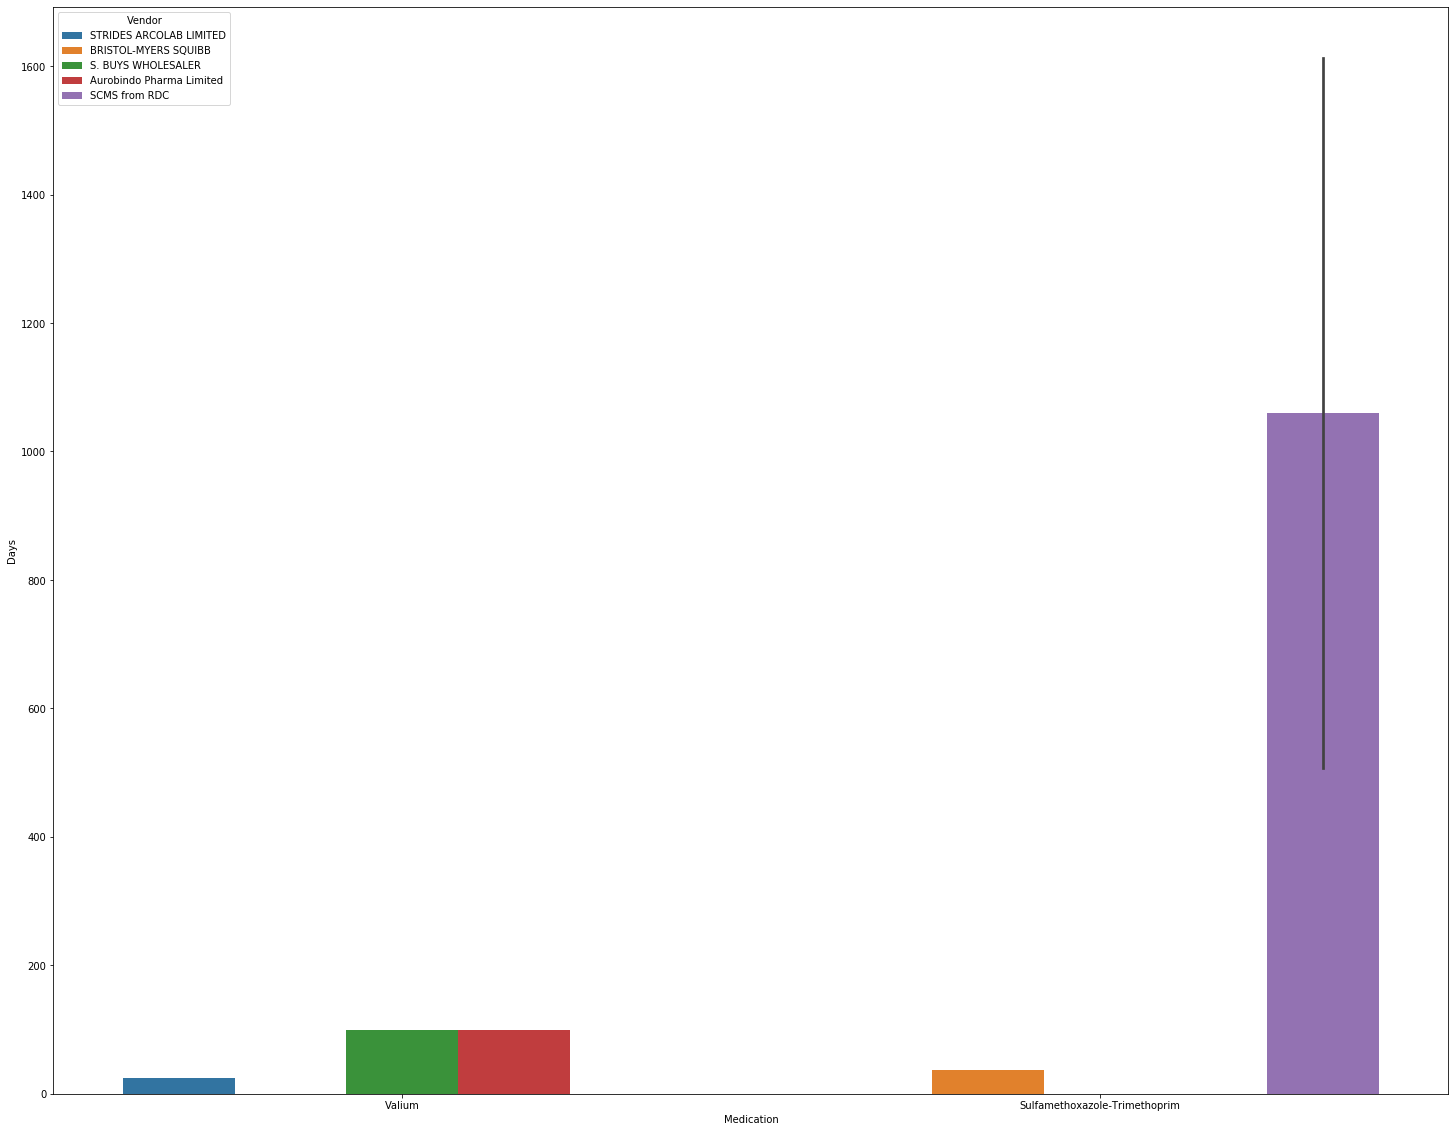

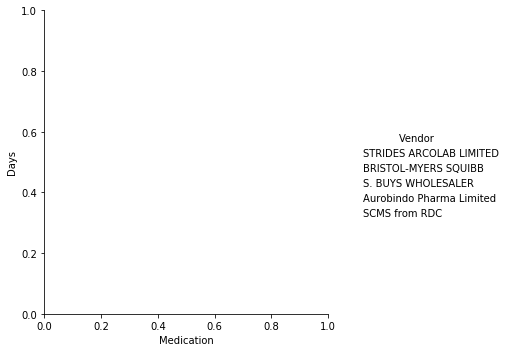

In [54]:
# Visualizing the output.

print('\n\nThe scatter plots for the clusters across various columns are')

import seaborn as sns
from matplotlib import rcParams

a4_dims = (25, 20)
fig, ax = plt.subplots(figsize=a4_dims)
sns.catplot(ax=ax, x="Medication", y="Days", hue="Vendor", kind="bar", data=df_vendor)


# Supply Management

In [55]:
# Cleaning Freight Cost (USD) column in df5.

df5['Freight Cost (USD)'] = pd.to_numeric(df5['Freight Cost (USD)'].astype(str).str.replace(',',''), errors='coerce').fillna(np.nan).astype(float)
df5['Freight Cost (USD)'].fillna(df5['Freight Cost (USD)'].mean(), inplace = True)
df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Suggest count,Delivery Time
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.340000,NaN,665,31
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.500000,NaN,308,196
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.780000,NaN,977,117
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.060000,NaN,807,122
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.080000,NaN,915,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,3424.44,11103.234819,705.79,379,3377
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,...,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,3424.44,11103.234819,161.71,415,3377
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,3424.44,11103.234819,5284.04,524,3408
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,11103.234819,134.03,640,3417


In [56]:
# Label encoding Vendor and Shipment Mode.

from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
le2 = LabelEncoder()

df5['Vendor'] = le1.fit_transform(df5['Vendor'])
df5['Shipment Mode'] = le2.fit_transform(df5['Shipment Mode'].astype(str))

filename='C:\\Users\\Ayanabha\\Blueronic\\Models\\vendor_label.pkl'
pickle.dump(le1, open(filename, 'wb'))

df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Suggest count,Delivery Time
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,0,...,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.340000,NaN,665,31
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,0,...,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.500000,NaN,308,196
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,0,...,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.780000,NaN,977,117
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,0,...,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.060000,NaN,807,122
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,0,...,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.080000,NaN,915,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,3424.44,11103.234819,705.79,379,3377
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,3,...,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,3424.44,11103.234819,161.71,415,3377
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,3,...,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,3424.44,11103.234819,5284.04,524,3408
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,11103.234819,134.03,640,3417


In [57]:
# Calculating and adding Shipment Cost column to df5.

df5['Shipment Cost'] = df5['Freight Cost (USD)']/(df5['Weight (Kilograms)'].astype(float) * df5['Line Item Quantity'])
df5['Shipment Cost'].replace(to_replace=[np.inf], value =np.nan,inplace=True)
df5['Shipment Cost'].fillna(df5['Shipment Cost'].mean(),inplace=True)
df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Suggest count,Delivery Time,Shipment Cost
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,0,...,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.340000,NaN,665,31,3.159271
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,0,...,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.500000,NaN,308,196,0.012630
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,0,...,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.780000,NaN,977,117,0.019342
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,0,...,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.060000,NaN,807,122,0.000270
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,0,...,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.080000,NaN,915,101,0.000158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,3.60,0.06,"Mylan, H-12 & H-13, India",No,3424.44,11103.234819,705.79,379,3377,0.000019
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,3,...,6.52,0.11,Hetero Unit III Hyderabad IN,No,3424.44,11103.234819,161.71,415,3377,0.000154
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,3,...,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,3424.44,11103.234819,5284.04,524,3408,0.000006
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,11103.234819,134.03,640,3417,0.000457


In [58]:
# Getting the latitudes and longitudes of all manufacturing sites in df5.

geocode=dict()
sites=list(set(df5['Manufacturing Site']))

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Blueronic")
for i in sites:
    location = geolocator.geocode(i,timeout=None)
    if location == None:
        geocode[i]=[np.nan,np.nan]
    else:
        geocode[i]=[location.latitude,location.longitude]
        
geocode


{'Boehringer Ingelheim Roxane US': [nan, nan],
 'GSK Ware (UK)': [nan, nan],
 'BI, Ingelheim, Germany': [49.9760129, 8.0532128],
 'Aspen-OSD, Port Elizabeth, SA': [nan, nan],
 'Alere Medical Co., Ltd.': [nan, nan],
 'BMS Meymac, France': [nan, nan],
 'Ranbaxy per Shasun Pharma': [nan, nan],
 'Not Applicable': [nan, nan],
 'Ranbaxy per Shasun Pharma Ltd': [nan, nan],
 'Cipla, Patalganga, India': [nan, nan],
 'MSD Patheon, Canada': [nan, nan],
 'Bio-Rad Laboratories': [33.64897205, -117.71755978070712],
 'Ranbaxy, Paonta Shahib, India': [nan, nan],
 'Ranbaxy Fine Chemicals LTD': [nan, nan],
 'Novartis Pharma AG, Switzerland': [47.55364695, 7.957880614328955],
 'Meditab (for Cipla) Daman IN': [nan, nan],
 'ABBVIE (Abbott) Japan Co. Ltd.': [nan, nan],
 'GSK Aranda': [41.663094799999996, -3.7204839159139755],
 'Aurobindo Unit VII, IN': [nan, nan],
 'OMEGA Diagnostics, UK': [nan, nan],
 'ABBVIE Labs North Chicago US': [nan, nan],
 'Gland Pharma, Hyderabad, IN': [nan, nan],
 'INVERNESS ANY': 

In [59]:
# Appending latitude and longitude of vendors to df5.

latitude=[]
longitude=[]

for i in df5['Manufacturing Site']:
    latitude.append(geocode[i][0])
    longitude.append(geocode[i][1])
    
df5['lat']=latitude
df5['long']=longitude

df5['lat'].fillna(df5['lat'].mean(), inplace = True)
df5['long'].fillna(df5['long'].mean(), inplace = True)

df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Suggest count,Delivery Time,Shipment Cost,lat,long
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,0,...,Ranbaxy Fine Chemicals LTD,Yes,13,780.340000,NaN,665,31,3.159271,24.252160,62.089017
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,0,...,"Aurobindo Unit III, India",Yes,358,4521.500000,NaN,308,196,0.012630,17.466053,78.383155
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,0,...,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.780000,NaN,977,117,0.019342,24.252160,62.089017
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,0,...,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.060000,NaN,807,122,0.000270,24.252160,62.089017
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,0,...,"Aurobindo Unit III, India",Yes,7590,45450.080000,NaN,915,101,0.000158,17.466053,78.383155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,"Mylan, H-12 & H-13, India",No,3424.44,11103.234819,705.79,379,3377,0.000019,24.252160,62.089017
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,3,...,Hetero Unit III Hyderabad IN,No,3424.44,11103.234819,161.71,415,3377,0.000154,17.406482,78.484877
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,3,...,Cipla Ltd A-42 MIDC Mahar. IN,No,3424.44,11103.234819,5284.04,524,3408,0.000006,24.252160,62.089017
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,Mylan (formerly Matrix) Nashik,Yes,1392,11103.234819,134.03,640,3417,0.000457,24.252160,62.089017


In [60]:
# DBSCAN for spatial data (manufacturing sites).

from sklearn.cluster import DBSCAN

X = df5[['lat','long']]
db_clustering=DBSCAN().fit(X)
set(list(db_clustering.labels_))


{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

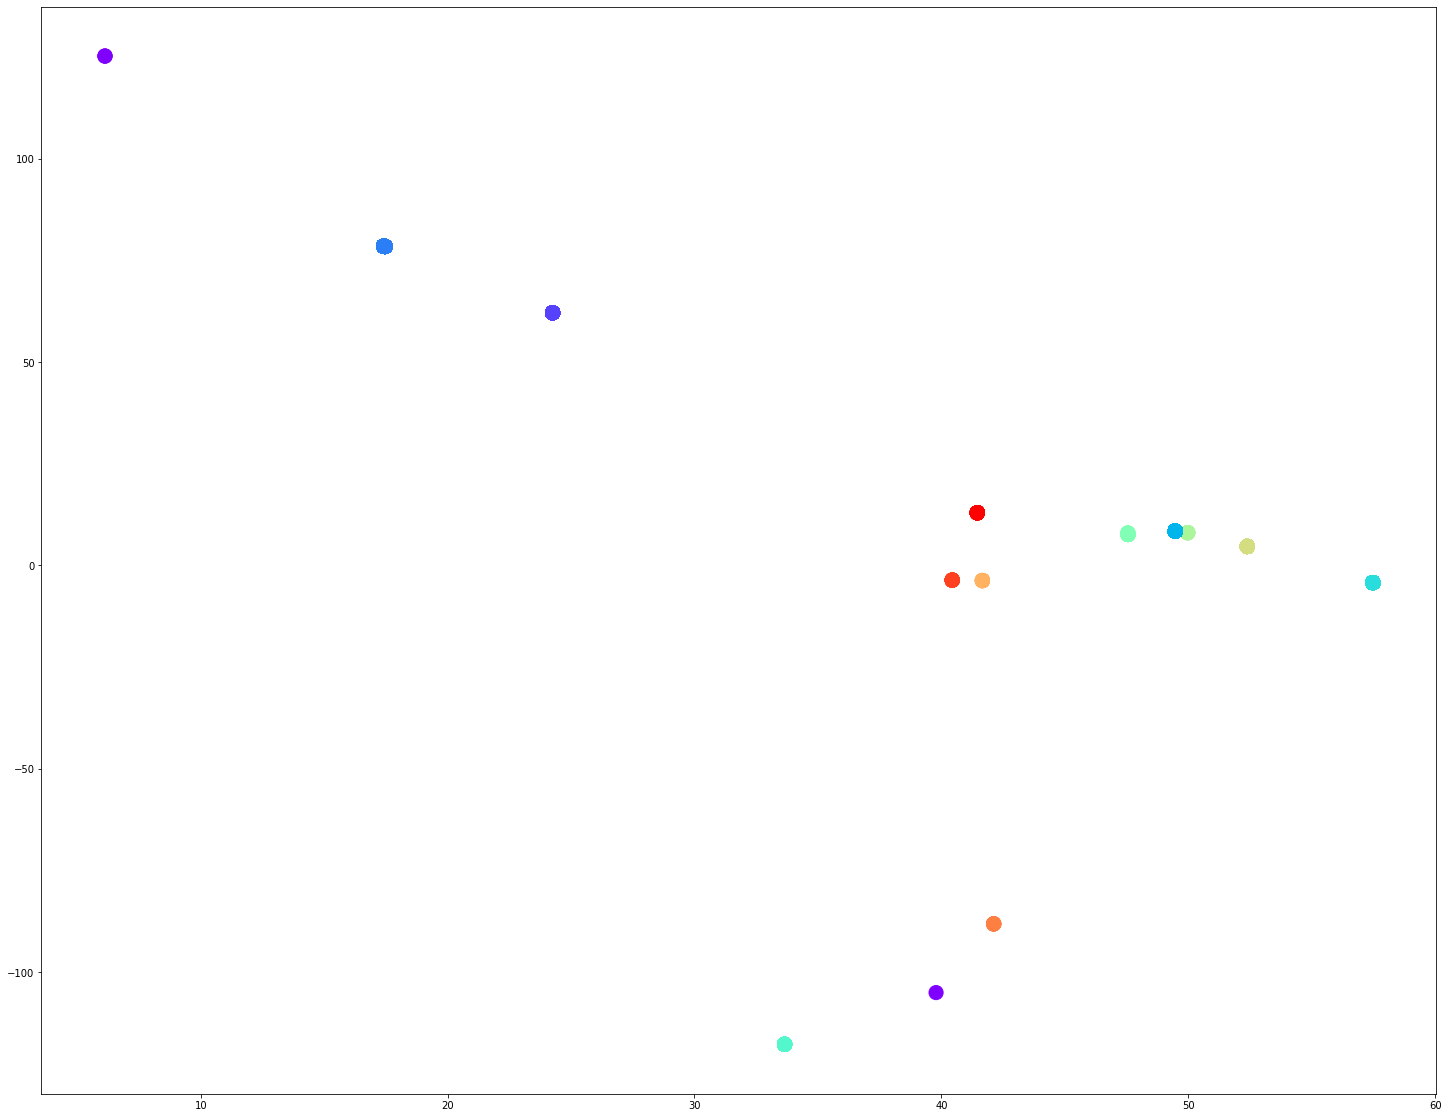

In [61]:
# Plotting the spatial data (manufacturing sites).

plt.figure(figsize=(25, 20))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=db_clustering.labels_, cmap='rainbow',s=200)
plt.show()


In [62]:
# Adding the cluster assignments as a column to df5.

df5['db_cluster']=list(db_clustering.labels_)
df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Suggest count,Delivery Time,Shipment Cost,lat,long,db_cluster
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,0,...,Yes,13,780.340000,NaN,665,31,3.159271,24.252160,62.089017,0
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,0,...,Yes,358,4521.500000,NaN,308,196,0.012630,17.466053,78.383155,1
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,0,...,Yes,171,1653.780000,NaN,977,117,0.019342,24.252160,62.089017,0
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,0,...,Yes,1855,16007.060000,NaN,807,122,0.000270,24.252160,62.089017,0
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,0,...,Yes,7590,45450.080000,NaN,915,101,0.000158,17.466053,78.383155,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,No,3424.44,11103.234819,705.79,379,3377,0.000019,24.252160,62.089017,0
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,3,...,No,3424.44,11103.234819,161.71,415,3377,0.000154,17.406482,78.484877,1
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,3,...,No,3424.44,11103.234819,5284.04,524,3408,0.000006,24.252160,62.089017,0
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,Yes,1392,11103.234819,134.03,640,3417,0.000457,24.252160,62.089017,0


In [63]:
# Appending a supply score column to df5.

df5['Supply score'] = df5['Shipment Mode'] + df5['Vendor'] + df5['Freight Cost (USD)'] + df5['Shipment Cost'] + df5['db_cluster']
df5.to_csv('C:\\Users\\Ayanabha\\Blueronic\\Datasets\\df_supply.csv')
df5


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Suggest count,Delivery Time,Shipment Cost,lat,long,db_cluster,Supply score
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,0,...,13,780.340000,NaN,665,31,3.159271,24.252160,62.089017,0,839.499271
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,0,...,358,4521.500000,NaN,308,196,0.012630,17.466053,78.383155,1,4535.512630
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,0,...,171,1653.780000,NaN,977,117,0.019342,24.252160,62.089017,0,1665.799342
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,0,...,1855,16007.060000,NaN,807,122,0.000270,24.252160,62.089017,0,16071.060270
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,0,...,7590,45450.080000,NaN,915,101,0.000158,17.466053,78.383155,1,45464.080158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,3424.44,11103.234819,705.79,379,3377,0.000019,24.252160,62.089017,0,11165.234839
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,3,...,3424.44,11103.234819,161.71,415,3377,0.000154,17.406482,78.484877,1,11166.234973
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,3,...,3424.44,11103.234819,5284.04,524,3408,0.000006,24.252160,62.089017,0,11165.234826
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,3,...,1392,11103.234819,134.03,640,3417,0.000457,24.252160,62.089017,0,11165.235276


In [64]:
# Train-test split for neural network.

X = df5[['Shipment Mode','Vendor','Freight Cost (USD)','Shipment Cost','db_cluster']]
y = df5[['Supply score']]


In [65]:
# Regressive Neural Network for supply score.

from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X, y)
filename='C:\\Users\\Ayanabha\\Blueronic\\Models\\neural_regr.pkl'
pickle.dump(regr, open(filename, 'wb'))

D:\Anaconda_Navigator\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
# Making an input dataframe X according to predicted meds.

l1 = []
l2 = []
l3 = []
l4 = []
l5 = []

for i in range(len(df5['Item Description'])):
    if(df5['Item Description'][i]==predicted_meds[0] or df5['Item Description'][i]==predicted_meds[1] or df5['Item Description'][i]==predicted_meds[2]):
        l1.append(X.iloc[i,:]['Shipment Mode'])
        l2.append(X.iloc[i,:]['Vendor'])
        l3.append(X.iloc[i,:]['Freight Cost (USD)'])
        l4.append(X.iloc[i,:]['Shipment Cost'])
        l5.append(X.iloc[i,:]['db_cluster'])
        
X_test = pd.DataFrame()
X_test['Shipment Mode'] = l1
X_test['Vendor'] = l2
X_test['Freight Cost (USD)'] = l3
X_test['Shipment Cost'] = l4
X_test['db_cluster'] = l5
X_test


,Shipment Mode,Vendor,Freight Cost (USD),Shipment Cost,db_cluster
0,0.0,58.0,11103.234819,0.009371,1.0
1,0.0,59.0,11103.234819,0.004382,0.0
2,0.0,13.0,5904.940000,0.000422,1.0
3,0.0,18.0,11103.234819,0.007813,0.0
4,0.0,62.0,11789.310000,0.000145,0.0
5,3.0,59.0,11103.234819,0.000065,0.0


In [67]:
# Make the predictions for supply score.

neural_pred = []
for i in range(X_test.shape[0]):
    neural_res = regr.predict([X_test.iloc[i,:]])
    neural_pred.append(neural_res.tolist()[0])
    
neural_pred


[11162.840675856381,
 11162.816340048907,
 5919.843407951428,
 11122.383169089198,
 11851.887907907834,
 11165.878043252329]

In [68]:
# Inverse transform and print the best supplier.

best_vendor_index = neural_pred.index(min(neural_pred))
le1.inverse_transform(X_test['Vendor'].astype(int)).tolist()[best_vendor_index]


'Aurobindo Pharma Limited'